<a href="https://colab.research.google.com/github/nicoaira/RNA-StruSiNet/blob/main/SS_windower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Instalations and imports
%%capture
!pip install forgi
!pip install ViennaRNA

import forgi.visual.mplotlib as fvm
import forgi
import pandas as pd
import gdown
from google.colab import files
import numpy as np
import math
import matplotlib.pyplot as plt
import os

In [ ]:
# @title Download structures datataset

url_id = '1wHL8oi0-4oRv3pfRu5g9QcJOsddieN6O' # @param {type:"string"}
url = 'https://drive.google.com/uc?id=' + url_id

output_file = 'unpaired_structures.tsv'
gdown.download(url, output_file, quiet=False)
# Load the CSV file into a pandas DataFrame
df = pd.read_csv(output_file, sep='\t')

Downloading...
From: https://drive.google.com/uc?id=1wHL8oi0-4oRv3pfRu5g9QcJOsddieN6O
To: /content/unpaired_structures.tsv
100%|██████████| 352k/352k [00:00<00:00, 53.1MB/s]


In [ ]:
#@title Function definitions

def dot_bracket_to_matrix_2(dot_bracket):
    L = len(dot_bracket)
    contact_matrix = np.zeros((L, L))

    look_for = [('(',')'),('[',']'),('{','}'),('<','>'), ('A', 'a')]

    for open, close in look_for:
        for i_x, base_x in enumerate(dot_bracket):
            if base_x == open:

                # Finding first closed bracket ahead
                first_closing = dot_bracket[i_x:].find(close)

                # Counting the number of ( between subject ( and first )
                N = dot_bracket[i_x:first_closing+i_x].count(open)

                # To find the ) matching the subject (, we have to search
                # for the (N)th ) ahead of our (
                c = 0
                i_match = 0
                for i_y, base_y in enumerate(dot_bracket[i_x+first_closing:]):
                    if base_y == open:
                        N += 1

                    if base_y == close:
                        c += 1
                        if c == N:

                            i_match =  i_x + first_closing + i_y
                            break

                contact_matrix[i_x, i_match] = 1
                contact_matrix[i_match, i_x] = 1

            else:
                continue

    return contact_matrix.astype(np.uint8)


def remove_pseudoknots(db):
  look_for = [('[',']'),('{','}'),('<','>'), ('A', 'a')]

  for open, close in look_for:

    db = db.replace(open, '.')
    db = db.replace(close, '.')

  return db


def draw_cuts(before, windows=[]):

  fig = plt.figure(figsize=(15, 10))

  plt.rcParams['figure.figsize'] = [8.0, 6.0]
  cg1 = forgi.load_rna(before, allow_many=False)
  fvm.plot_rna(cg1, text_kwargs={"fontweight":"black"}, lighten=0.7,
              backbone_kwargs={"linewidth":3})
  plt.title('Before')

  plt.show()

  fig = plt.figure(figsize=(15, 10))

  n_rows = int(math.ceil(len(windows) / 2))

  for id, window in enumerate(windows):

    plt.subplot(n_rows, 2, id+1)
    plt.rcParams['figure.figsize'] = [8.0, 6.0]
    cg = forgi.load_rna(window, allow_many=False)
    fvm.plot_rna(cg, text_kwargs={"fontweight":"black"}, lighten=0.7,
                backbone_kwargs={"linewidth":3})
    plt.title('Cut #' + str(id+1))

  plt.show()


def plot_array(array, x_cut=None, reverse_colors=False):
  ''' Plots a bar showing the different values along the 1D array with
  different colors '''

  colors = plt.cm.viridis(array)

  # Create a figure and axis
  fig, ax = plt.subplots(figsize=(10, 1))

  # Plot the color bar
  cax = ax.matshow([array], cmap='viridis', aspect='auto')

  if reverse_colors:
    cax.set_cmap('viridis_r')

  # Remove y-axis ticks and labels
  ax.set_yticks([])

  # Add color bar
  fig.colorbar(cax, orientation='horizontal', aspect=50)
  if x_cut:
    ax.axvline(x=x_cut, color='red', linestyle='dashed')

  # Show the plot
  plt.show()


def find_one(arr):
  ''' Given an array, it returns i where arr[i] == 1 '''

  if np.any(arr == 1):
      return np.argmax(arr)
  else:
      return np.nan


def cut_structure(db, x_cut, y_cut):
  ''' Given a dotbracket structure and two coordinates of two paired bases
  inside a stem, it returns two slices of the structure that results from
  cutting it in that particular location
  '''

  first = min(x_cut, y_cut)
  last = max(x_cut, y_cut)

  cut1 = db[:first+1] + db[last:]
  cut2 = db[first+1:last]

  return cut1, cut2

def get_slices_length_difs(db):
  ''' This function creates a slices_length_difs, which is an array that shows
  what would be the difference of the length of the resulting slices when
  cutting the secondary structure in each position.
  '''

  matrix = dot_bracket_to_matrix_2(db)

  half_matrix = matrix.copy()
  half_matrix[np.tril_indices_from(half_matrix, k=-1)] = 0

  slices_length_difs = np.full(matrix.shape[0], np.nan)

  for x_index, x in enumerate(half_matrix):

    y_index = find_one(x)

    if not(np.isnan(y_index)):
      first = min(x_index, y_index)
      last = max(x_index, y_index)
      cut1 = db[:first+1] + db[last:]
      cut2 = db[first+1:last]
      dist = abs(len(cut1)-len(cut2))
      slices_length_difs[x_index] = dist

  return slices_length_difs


def get_best_cut_coords(db, slices_length_difs):
  ''' Using the slices_length_difs, it returns the x and y coordinates of the
  structure, where the cut produce the smaller difference between the resulting
  slices '''

  matrix = dot_bracket_to_matrix_2(db)

  # Find indices where the values are not equal to np.nan
  valid_indices =  np.where(~np.isnan(slices_length_difs))[0]

  # # Find the index of the minimum value among the valid indices
  cut_x_coord = valid_indices[np.argmin(slices_length_difs[valid_indices])]
  cut_y_coord = find_one(matrix[cut_x_coord])

  return (cut_x_coord, cut_y_coord)


def get_shift_cut_distances(db, slices_length_difs):
  ''' Given a dot bracket structure, it creates an array that maps the
  difference in the length of all possible dobuble strand cuts in stems of the
  structure
  '''

  (x_best, y_best) = get_best_cut_coords(db, slices_length_difs)

  matrix = dot_bracket_to_matrix_2(db)

  half_matrix = matrix.copy()
  half_matrix[np.tril_indices_from(half_matrix, k=-1)] = 0

  shift_cut_distances = np.full(matrix.shape[0], np.nan)

  for x_index, x in enumerate(half_matrix):

    y_index = find_one(x)

    if not(np.isnan(y_index)):

      cut_distance = math.sqrt((x_best - x_index)**2 + (y_best - y_index)**2)
      shift_cut_distances[x_index] = cut_distance

  return shift_cut_distances


def get_shifted_cut_coords(db, slices_length_difs, shift_cut_distances,
                    thetha1, thetha2,
                    min_distance_init, min_distance_limit, min_distance_step,
                    max_difference_init, max_difference_limit, max_difference_step
                    ):
  ''' Given a dotbracket structure, a slices_length_difs and a shift_cut_distances,
  it selects a x and y coordinates for a cut that is shifted some positions
  with respect to the optimal x and y (the ones returned by get_best_cut_coords)
  These x and y are estimated in a way that the new cut is made at certain
  distance from the optimal cut site, but trying to keep a low difference
  between the resulting slices. The parameters thetha1 and theta2 give different
  weights to ponderate more getting a big distance respect the optimal cut site
  (thetha1) or getting a small difference between the resulting slices (thetha2)
  We set the inital minimal distance respect the optimal site (min_distance_init)
  which will be decreasing a min_distance_step each time that no cut site is
  found with these parameters, until reaching a limit of min_distance_limit
  Also, we set the initial max difference between the size of the resulting cuts
  (max_difference_init), which tolerance also will be increasing an amount of
  max_difference_step each time that no cut site is found, until reaching a
  limit of max_difference_limit
  '''

  dist_dif_array = np.where((shift_cut_distances != -1) & (slices_length_difs != -1),  #### ALTERTA REVISAR EL != -1!!!!
                    (thetha1 * shift_cut_distances - thetha2 * slices_length_difs ),
                    -1)

  x_selected_coord = None

  min_distance = min_distance_init
  max_difference = max_difference_init

  distance_limit_reached = False
  difference_limit_reached = False

  while (x_selected_coord == None):
    try:
      valid_indices =  np.where(~np.isnan(shift_cut_distances) &
                                (shift_cut_distances > min_distance) &
                                 (slices_length_difs < max_difference)
                                 )[0]

      x_selected_coord = valid_indices[np.argmax(dist_dif_array[valid_indices])]
    except ValueError:
      if min_distance > min_distance_limit:
        min_distance -= min_distance_step
      else:
        distance_limit_reached = True
      if max_difference < max_difference_limit:
        max_difference += max_difference_step
      else:
        difference_limit_reached = True
    finally:
      if difference_limit_reached and distance_limit_reached:
        return None

  ############

  matrix = dot_bracket_to_matrix_2(db)

  y_selected_coord = find_one(matrix[x_selected_coord])

  return (x_selected_coord, y_selected_coord)


def get_ss_windows(db, max_size=120, mode='best',
                   thetha1=None, thetha2=None,
                   min_distance_init=None,
                   min_distance_limit=None,
                   min_distance_step=1,
                   max_difference_init=None,
                   max_difference_limit=None,
                   max_difference_step=1):

  windows = [db]
  big_windows = [w for w in windows if len(w) > max_size]
  windows = [w for w in windows if len(w) <= max_size]



  first_cut = True

  while any(big_windows):
    for window in big_windows:

      slices_length_difs = get_slices_length_difs(window)

      if mode=='best' or (not first_cut):
        (x_coord, y_coord) = get_best_cut_coords(window, slices_length_difs)

      elif mode=='shifted' and first_cut:

        first_cut = False
        shift_cut_distances = get_shift_cut_distances(window, slices_length_difs)

        coords = shift_cut_distances = get_shifted_cut_coords(
                  window, slices_length_difs, shift_cut_distances,
                  thetha1, thetha2,
                  min_distance_init, min_distance_limit, min_distance_step,
                  max_difference_init, max_difference_limit, max_difference_step
                  )

        if coords is None:
          return []

        else:
          x_coord = coords[0]
          y_coord = coords[1]

      cut1, cut2 = cut_structure(window, x_coord, y_coord)

      if window != cut1 and windows != cut2:
        windows.append(cut1)
        windows.append(cut2)

    big_windows = [w for w in windows if (len(w) > max_size and w != '.'*len(w))]
    windows = [w for w in windows if len(w) <= max_size]

    #Filter out only dots windows
    windows = [w for w in windows if w != '.'*len(w)]
    # print(big_windows)

  return windows

In [ ]:
from tqdm import tqdm

tqdm.pandas(desc='Removing pseudoknots')
df['structures_wo_pk'] = df.progress_apply(lambda x: remove_pseudoknots(x['structure']),
                                      axis=1)

tqdm.pandas(desc='Generating slided windows')
df['slided_windows'] = df.progress_apply(lambda x: get_ss_windows( x['structures_wo_pk'], max_size=220, mode='shifted',
                                                          thetha1=1, thetha2=8,
                                                          min_distance_init=80,
                                                          min_distance_limit=20,
                                                          min_distance_step=3,
                                                          max_difference_init=10,
                                                          max_difference_limit=180,
                                                          max_difference_step=4), axis=1)


Generating slided windows: 100%|██████████| 506/506 [00:09<00:00, 54.47it/s]


In [ ]:
df_exploded = df['slided_windows'].explode().reset_index(drop=True)
count_no_cuts = df_exploded[df_exploded == 'NoCuts'].count()

print("Number of rows with 'NoCuts':", count_no_cuts)

Number of rows with 'NoCuts': 38


In [ ]:
slided_windows = get_ss_windows( RNP_333, max_size=220, mode='shifted',
                          thetha1=1, thetha2=8,
                          min_distance_init=80,
                          min_distance_limit=40,
                          min_distance_step=3,
                          max_difference_init=10,
                          max_difference_limit=180,
                          max_difference_step=8)

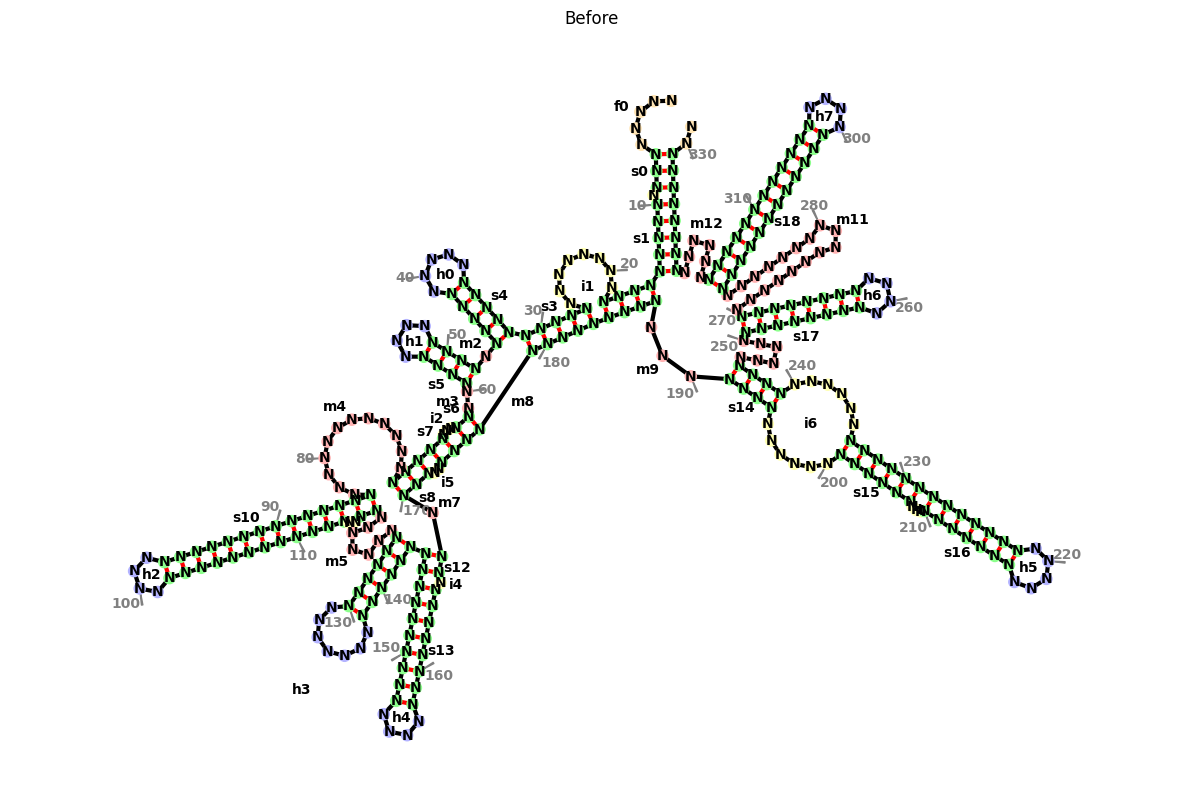

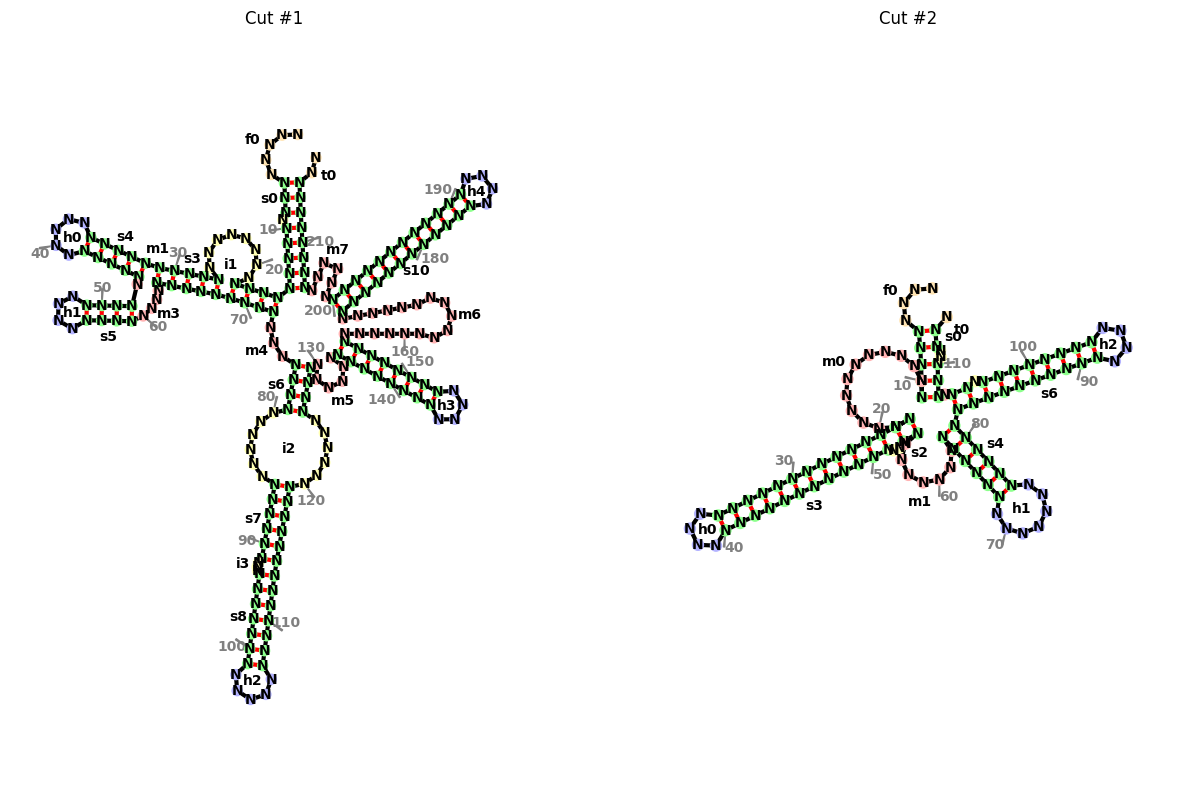

In [ ]:
draw_cuts(RNP_333, windows=slided_windows[0:2])

In [ ]:
best_windows = get_ss_windows( RNP_333, max_size=220, mode='best',
                          thetha1=.9, thetha2=1,
                          min_distance_init=40,
                          min_distance_limit=15,
                          min_distance_step=1,
                          max_difference_init=5,
                          max_difference_limit=150,
                          max_difference_step=1)

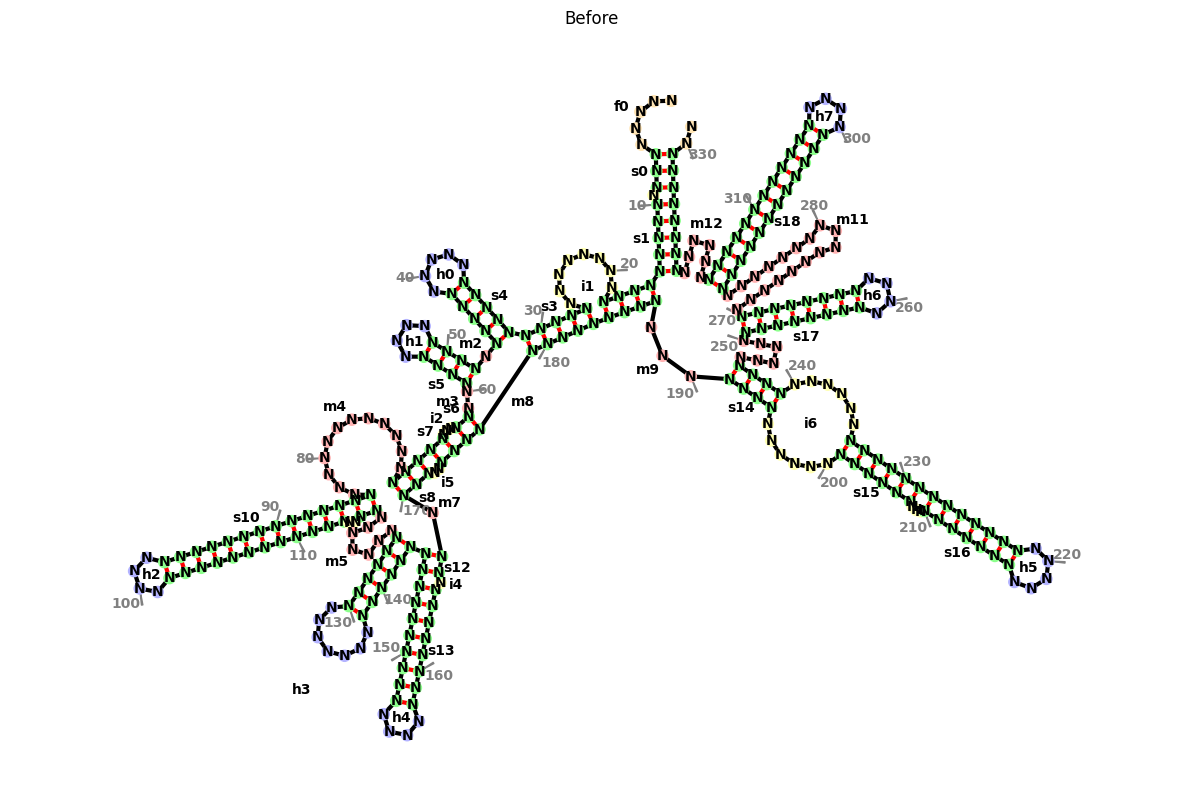

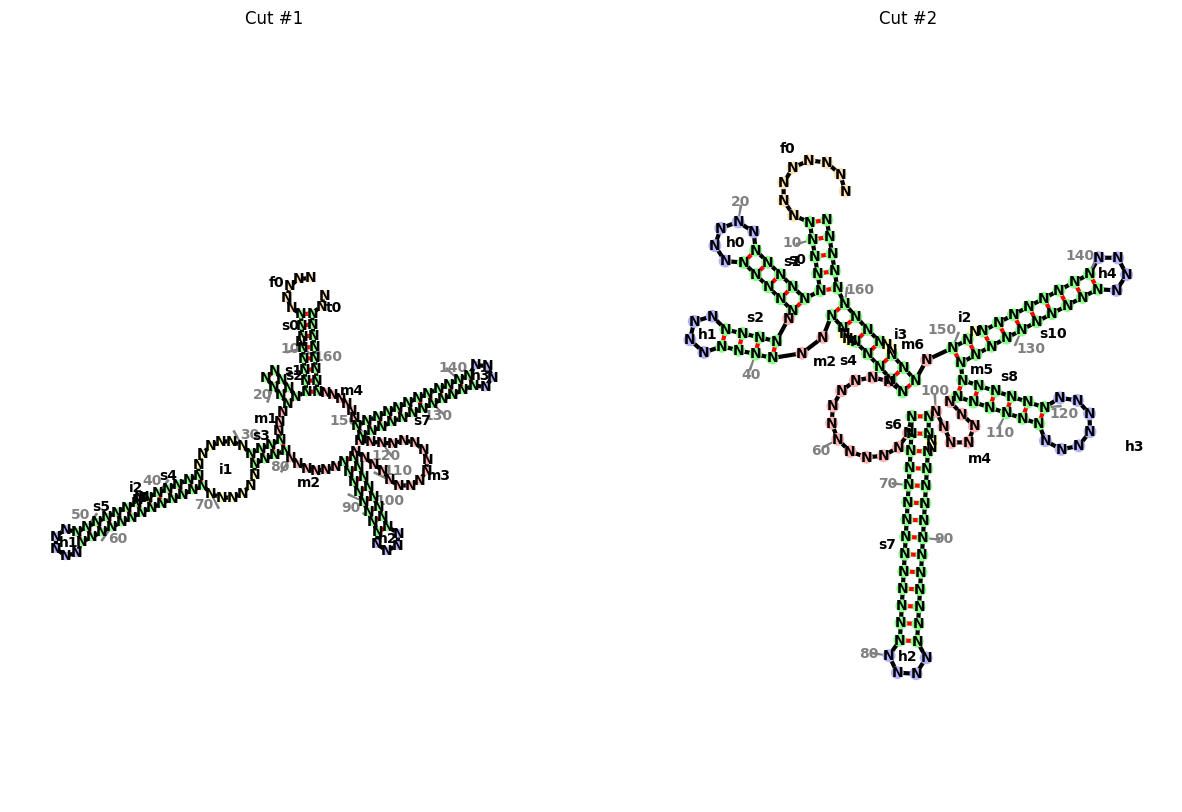

In [ ]:
draw_cuts(RNP_333, windows=best_windows)

In [ ]:
#@title Define RNP_333


RNP_333='.....(((.(((((((((...[[[[.((((((((((.....)))))(((((....)))).)((...(((((............((((((((((((((....))))))))))))..)).......((((((.......))))))((((((((((....)))))))).)).)))..)))))))))))))...((((......((((((...(((((((.]]]])))))))))))))......))))......((((((((....)))))))).................((((((((((((....))))))))))))......))))))))..'
RNP_333 = remove_pseudoknots(RNP_333)

In [ ]:
# shift_cut_distances, x_best = get_cutting_distances(RNP_333)
# slices_length_difs, (x_best, y_best) = get_best_cut(RNP_333)

thetha1 = .9
thetha2 = 1

min_distance_init = 40
min_distance_limit = 15
min_distance_step = 1

max_difference_init = 5
max_difference_limit = 150
max_difference_step = 1


x_selected, y_selected = get_shifted_cut(RNP_333, thetha1, thetha2,
                             min_distance_init, min_distance_limit, min_distance_step,
                             max_difference_init, max_difference_limit, max_difference_step
                             )



# cut1, cut2 = cut_structure(RNP_333, x_selected, y_selected)

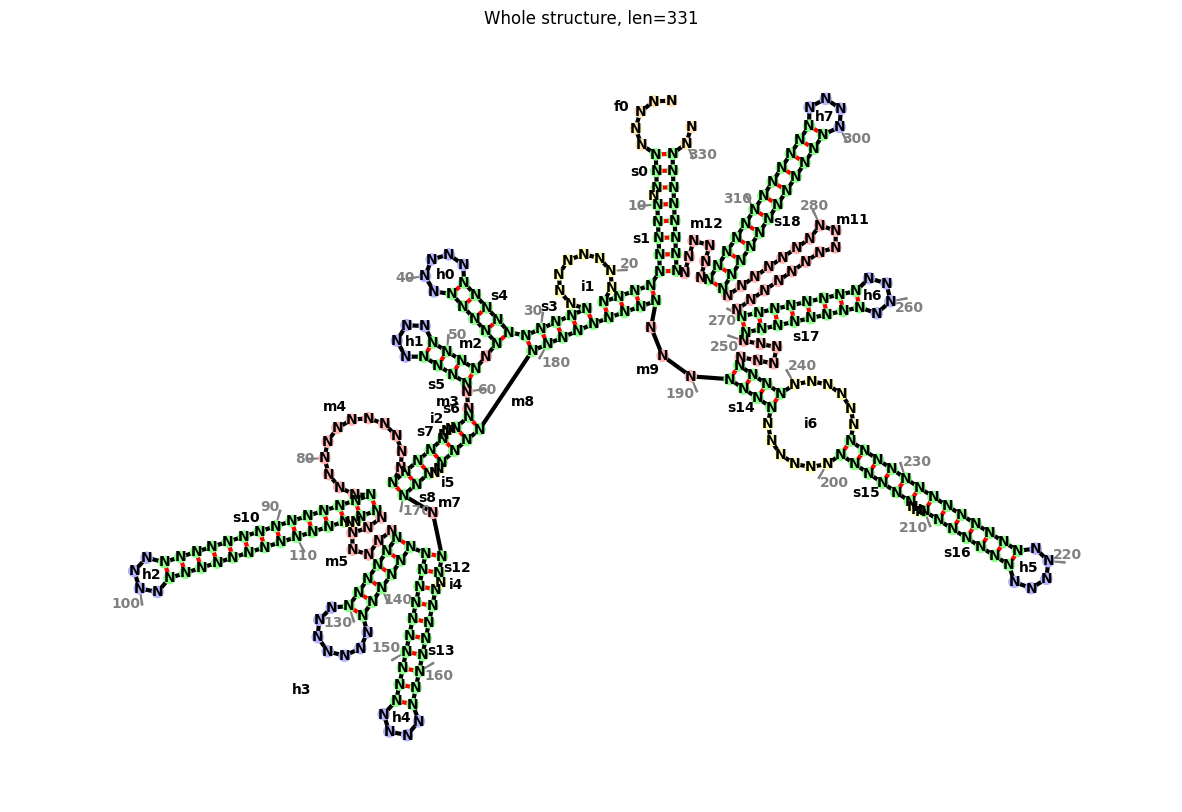

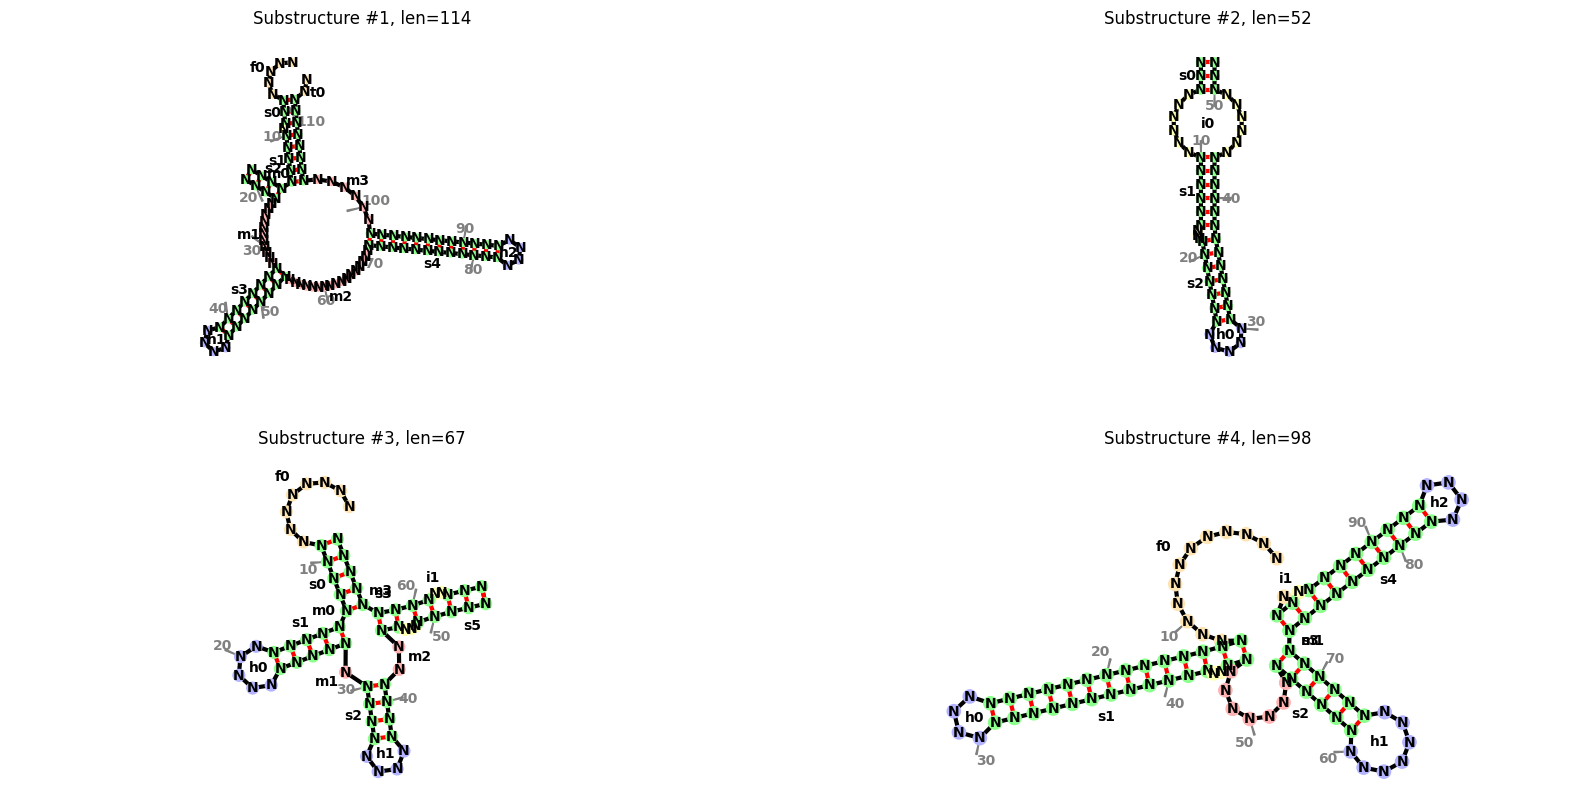

In [ ]:
#@title Example (RNP_333 + stride) windows
RNP_333='.....(((.(((((((((...[[[[.((((((((((.....)))))(((((....)))).)((...(((((............((((((((((((((....))))))))))))..)).......((((((.......))))))((((((((((....)))))))).)).)))..)))))))))))))...((((......((((((...(((((((.]]]])))))))))))))......))))......((((((((....)))))))).................((((((((((((....))))))))))))......))))))))..'
RNP_333 = remove_pseudoknots(RNP_333)

max_windows_size = 150 # @param {type:"integer"}
RNP_333_stride2 = RNP_333
windows = get_ss_windows(RNP_333_stride2, max_size=max_windows_size)

#@title Draw example (RNP_333) windows

fig = plt.figure(figsize=(15, 10))

plt.rcParams['figure.figsize'] = [8.0, 6.0]
cg1 = forgi.load_rna(RNP_333_stride2, allow_many=False)
fvm.plot_rna(cg1, text_kwargs={"fontweight":"black"}, lighten=0.7,
            backbone_kwargs={"linewidth":3})
plt.title(f'Whole structure, len={len(RNP_333_stride2)}')

plt.show()

if len(windows) % 2 == 0:
  num_rows = int(len(windows)/2)
else:
  num_rows = int(math.ceil(len(windows)/2))

fig = plt.figure(figsize=(20, 10))


for index, window in enumerate(windows):
  # Plot the first matrix
  plt.subplot(num_rows, 2, index+1)
  plt.rcParams['figure.figsize'] = [8.0, 6.0]
  # cg1 = forgi.load_rna(dot_bracket1, allow_many=False)
  cg = forgi.load_rna(window, allow_many=False)
  fvm.plot_rna(cg, text_kwargs={"fontweight":"black"}, lighten=0.7,
              backbone_kwargs={"linewidth":3})
  plt.title(f'Substructure #{index+1}, len={len(window)}')

plt.show()

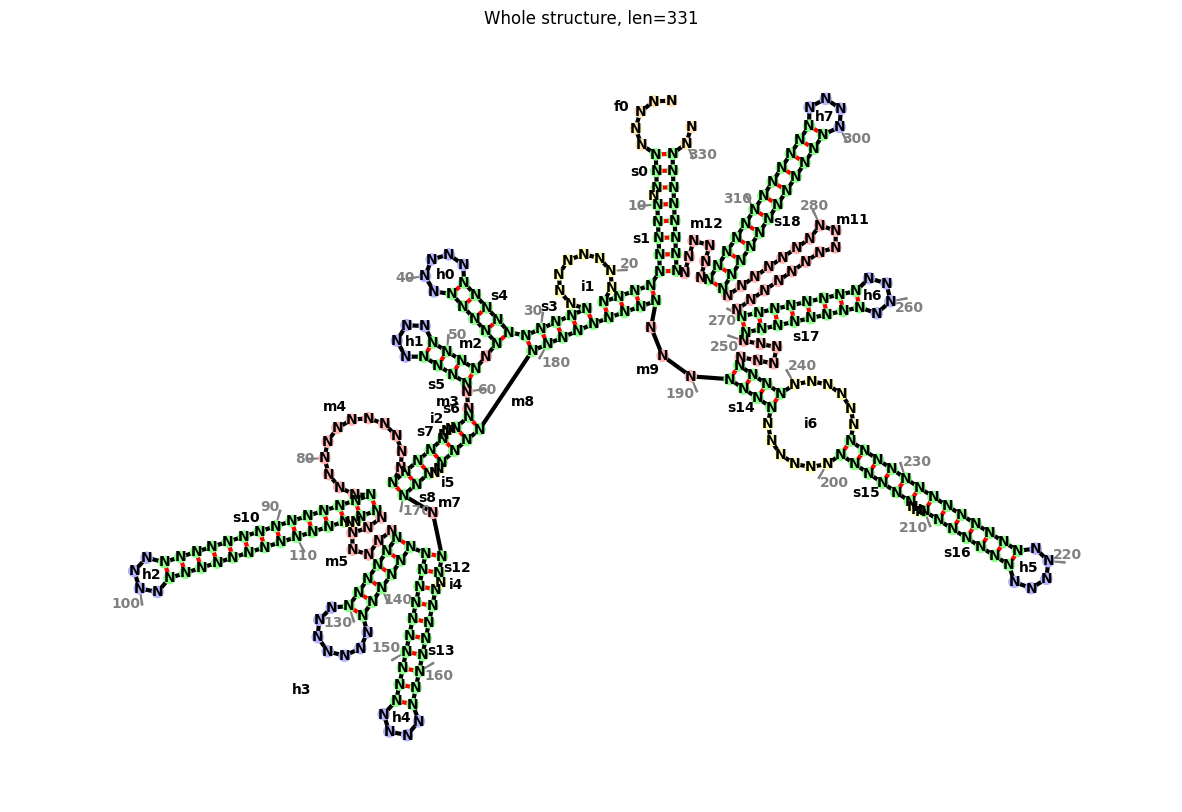

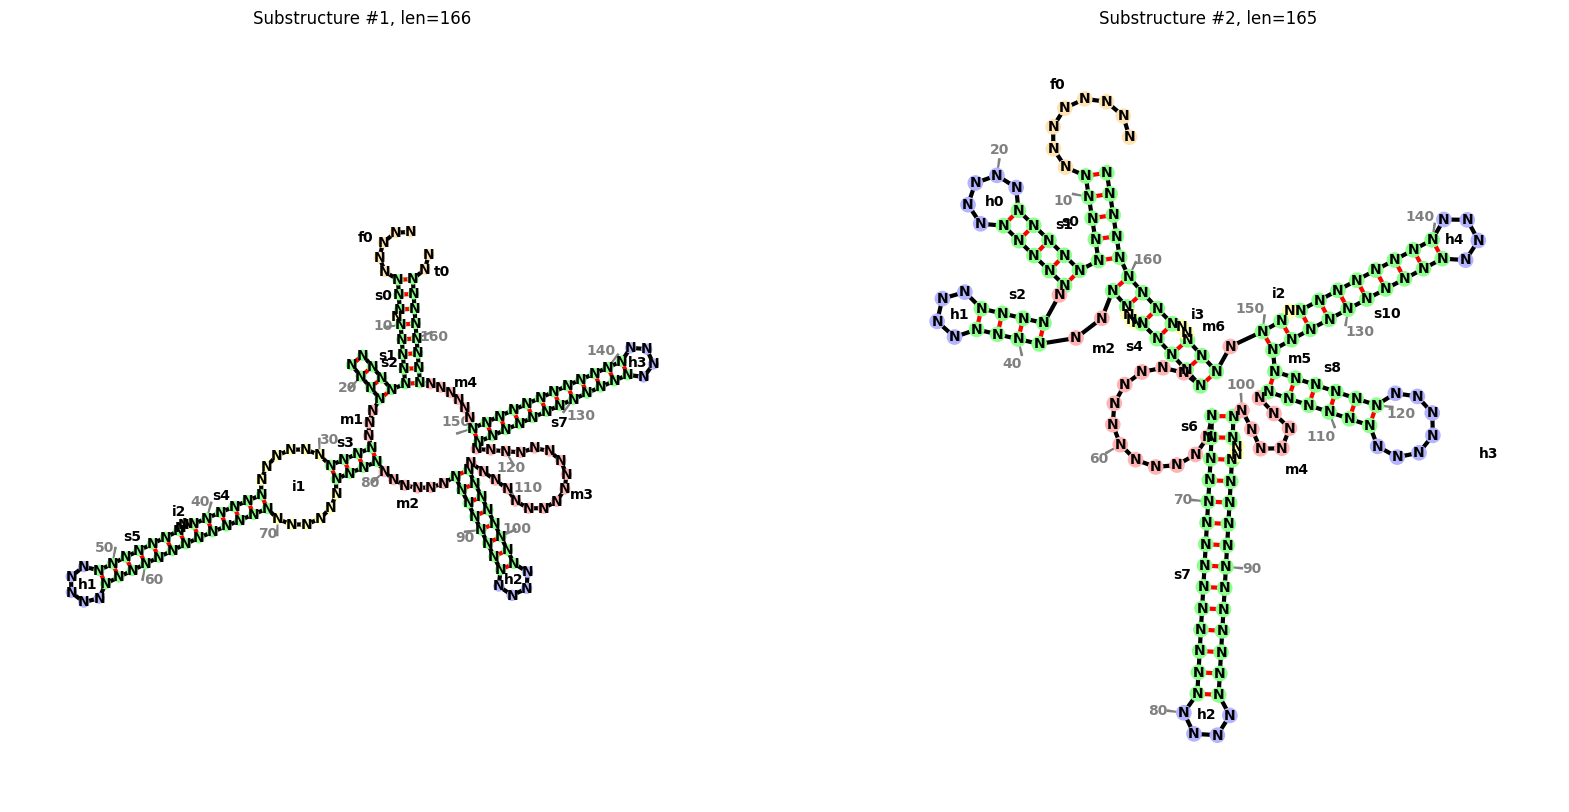

In [ ]:
#@title Example (RNP_333 + stride) windows
RNP_333='.....(((.(((((((((...[[[[.((((((((((.....)))))(((((....)))).)((...(((((............((((((((((((((....))))))))))))..)).......((((((.......))))))((((((((((....)))))))).)).)))..)))))))))))))...((((......((((((...(((((((.]]]])))))))))))))......))))......((((((((....)))))))).................((((((((((((....))))))))))))......))))))))..'
RNP_333 = remove_pseudoknots(RNP_333)

max_windows_size = 219 # @param {type:"integer"}
RNP_333_stride2 = RNP_333
windows = get_ss_windows(RNP_333_stride2, max_size=max_windows_size)

#@title Draw example (RNP_333) windows

fig = plt.figure(figsize=(15, 10))

plt.rcParams['figure.figsize'] = [8.0, 6.0]
cg1 = forgi.load_rna(RNP_333_stride2, allow_many=False)
fvm.plot_rna(cg1, text_kwargs={"fontweight":"black"}, lighten=0.7,
            backbone_kwargs={"linewidth":3})
plt.title(f'Whole structure, len={len(RNP_333_stride2)}')

plt.show()

if len(windows) % 2 == 0:
  num_rows = int(len(windows)/2)
else:
  num_rows = int(math.ceil(len(windows)/2))

fig = plt.figure(figsize=(20, 10))


for index, window in enumerate(windows):
  # Plot the first matrix
  plt.subplot(num_rows, 2, index+1)
  plt.rcParams['figure.figsize'] = [8.0, 6.0]
  # cg1 = forgi.load_rna(dot_bracket1, allow_many=False)
  cg = forgi.load_rna(window, allow_many=False)
  fvm.plot_rna(cg, text_kwargs={"fontweight":"black"}, lighten=0.7,
              backbone_kwargs={"linewidth":3})
  plt.title(f'Substructure #{index+1}, len={len(window)}')

plt.show()

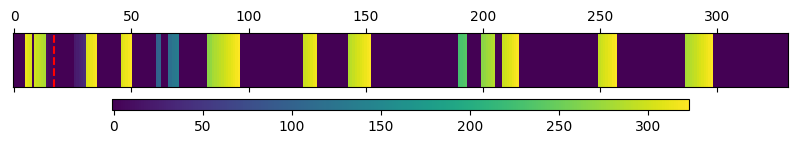

In [ ]:
#@title Draw example (RNP_333) distance array


slices_length_difs, coord = get_best_cut(RNP_333)
plot_array(slices_length_difs, coord[0])

In [ ]:
#@title Get example (RNP_333) windows

max_windows_size = 149 # @param {type:"integer"}
RNP_333_stride = '((((((((((..'+RNP_333+'..))))))))))'
windows = get_ss_windows(RNP_333_stride, max_size=max_windows_size)

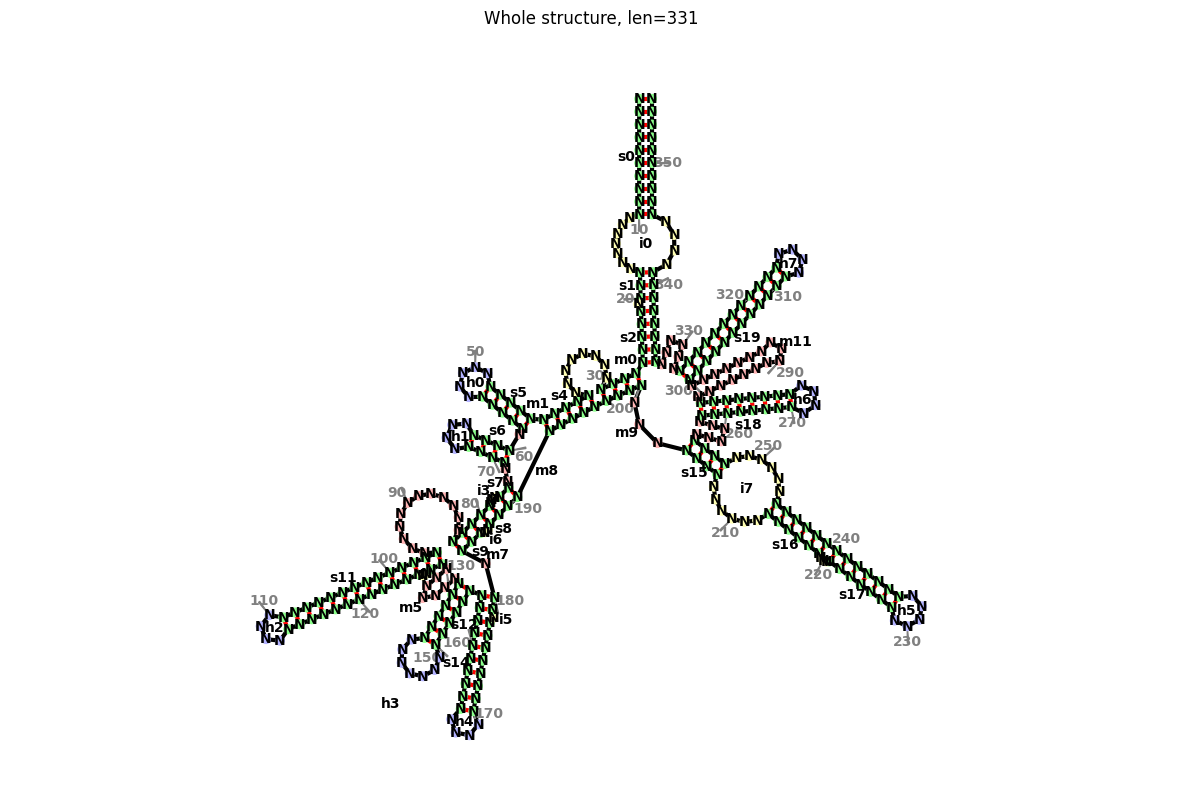

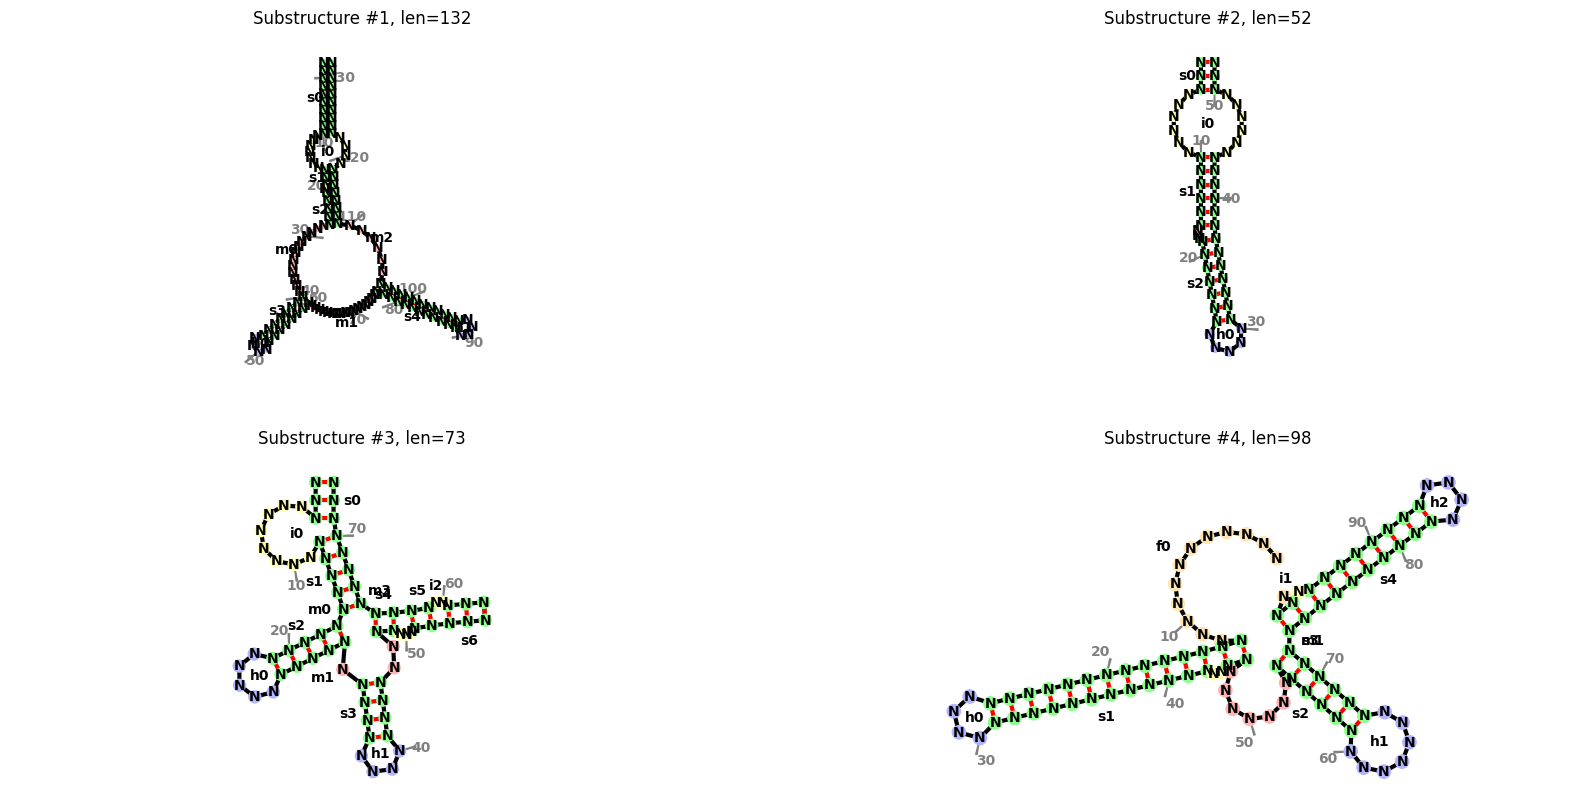

In [ ]:
#@title Draw example (RNP_333) windows

fig = plt.figure(figsize=(15, 10))

plt.rcParams['figure.figsize'] = [8.0, 6.0]
cg1 = forgi.load_rna(RNP_333_stride, allow_many=False)
fvm.plot_rna(cg1, text_kwargs={"fontweight":"black"}, lighten=0.7,
            backbone_kwargs={"linewidth":3})
plt.title(f'Whole structure, len={len(RNP_333)}')

plt.show()

if len(windows) % 2 == 0:
  num_rows = int(len(windows)/2)
else:
  num_rows = int(math.ceil(len(windows)/2))

fig = plt.figure(figsize=(20, 10))


for index, window in enumerate(windows):
  # Plot the first matrix
  plt.subplot(num_rows, 2, index+1)
  plt.rcParams['figure.figsize'] = [8.0, 6.0]
  # cg1 = forgi.load_rna(dot_bracket1, allow_many=False)
  cg = forgi.load_rna(window, allow_many=False)
  fvm.plot_rna(cg, text_kwargs={"fontweight":"black"}, lighten=0.7,
              backbone_kwargs={"linewidth":3})
  plt.title(f'Substructure #{index+1}, len={len(window)}')

plt.show()